Value function grid using optimal policy:
[[0.73831709 0.43101485 0.4272577  0.13312982]
 [0.74283556 0.         0.31570824 0.        ]
 [0.80142567 0.74897738 0.56928566 0.        ]
 [0.         0.89670314 0.93259736 0.        ]]


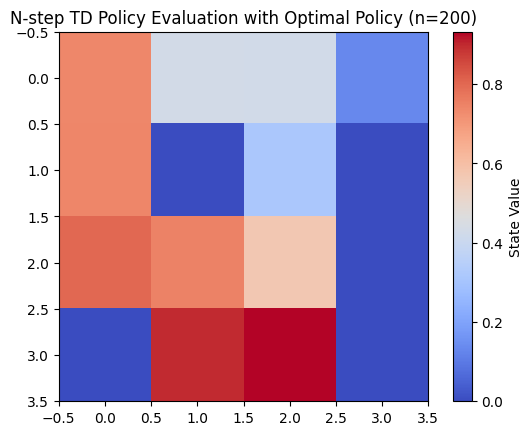

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from mdps import *
mdp = FrozenLakeMDP
# Parameters for the N-step TD algorithm
discount_factor = 0.99 # Gamma, discount factor for future rewards
learning_rate = 0.1    # Alpha, learning rate for value function updates
n_steps = 200          # Number of steps for the N-step TD evaluation
num_states = 16        # Total number of states in the FrozenLake environment (4x4 grid)
num_actions = 4        # Number of possible actions (up, down, left, right)

# Initialize the value function V(s) to zero for all states
value_function = np.zeros(num_states)

# Define the given optimal policy for specific states in the environment
optimal_policy_actions = {
    0: 0, 1: 3, 2: 3, 3: 3, 4: 0,
    6: 0, 8: 3, 9: 1, 10: 0, 13: 2, 14: 1
}

# Initialize a random policy, with probabilities equally distributed across actions for each state
random_policy_probabilities = np.random.dirichlet(np.ones(num_actions), size=num_states)

def take_action_in_mdp(current_state, selected_action):
    """
    Takes the given action in the Markov Decision Process (MDP) from the current state.
    
    Parameters:
    - current_state:   The current state in the environment.
    - selected_action: The action chosen by the agent.
    
    Returns:
    - next_state: The resulting state after taking the action.
    - reward:     The reward obtained by taking the action.
    - done:       A boolean indicating whether the episode has ended.
    """
    transitions = mdp[current_state][selected_action]
    probabilities, next_states, rewards, done_flags = zip(*transitions)
    
    # Choose the next state based on the probabilities of the transitions
    next_state = np.random.choice(next_states, p=probabilities)
    reward = rewards[next_states.index(next_state)]
    done = done_flags[next_states.index(next_state)]
    
    return next_state, reward, done

def n_step_temporal_difference_evaluation(n_steps, policy_type="random", num_episodes=5000):
    """
    Performs N-step Temporal Difference (TD) Policy Evaluation.
    
    This function evaluates either a random policy or an optimal policy, based on the given policy_type.
    It updates the value function for each state using N-step TD over multiple episodes.
    
    Parameters:
    - n_steps: The number of steps to use in N-step TD.
    - policy_type: Either "random" or "optimal", determining the policy used for action selection.
    - num_episodes: The total number of episodes to run for evaluation.
    
    Returns:
    - value_function: The updated state value function after N-step TD evaluation.
    """
    global value_function
    for episode in range(num_episodes):
        # Start at a random initial state for each episode
        current_state = np.random.choice(list(mdp.keys()))
        
        # Store the states and rewards encountered in the episode
        episode_states = [current_state]
        episode_rewards = [0]  # Initialize with reward 0 for the current state
        
        # Generate an episode by taking n steps (or until the episode terminates)
        for step in range(n_steps):
            # Determine the action based on the chosen policy (random or optimal)
            if policy_type == "optimal" and current_state in optimal_policy_actions:
                selected_action = optimal_policy_actions[current_state]  # Use the optimal action
            else:
                selected_action = np.random.choice(np.arange(num_actions), p=random_policy_probabilities[current_state])  # Use random policy
            
            # Take the action in the MDP and observe the next state, reward, and done flag
            next_state, reward, done = take_action_in_mdp(current_state, selected_action)
            
            # Append the next state and reward to the lists
            episode_states.append(next_state)
            episode_rewards.append(reward)
            
            # If the episode is done (terminal state reached), stop further steps
            if done:
                break
            
            # Move to the next state for the next step
            current_state = next_state
        
        # Update the value function using N-step Temporal Difference (TD)
        for step in range(len(episode_states) - 1):
            # Calculate the return G using the rewards and the current value function
            G = sum([discount_factor ** i * episode_rewards[step + i] for i in range(len(episode_rewards) - step)])
            
            # If the episode didn't finish early, add the value of the future state after n steps
            if step + n_steps < len(episode_states):
                G += discount_factor ** n_steps * value_function[episode_states[step + n_steps]]
            
            # Update the value function for the current state
            state_to_update = episode_states[step]
            value_function[state_to_update] += learning_rate * (G - value_function[state_to_update])
    
    return value_function

# Set whether to use the "random" policy or the "optimal" policy
policy_type_choice = "optimal"

# Perform N-step TD policy evaluation using the chosen policy type
value_function = n_step_temporal_difference_evaluation(n_steps, policy_type=policy_type_choice)

# Reshape the value function into a 4x4 grid (as the FrozenLake is a 4x4 environment)
value_function_grid = value_function.reshape((4, 4))

# Display the resulting value function as a 2D array
print(f"Value function grid using {policy_type_choice} policy:")
print(value_function_grid)

# Plot the value function grid as a heatmap
plt.imshow(value_function_grid, cmap='coolwarm', interpolation='none')
plt.colorbar(label='State Value')
plt.title(f'N-step TD Policy Evaluation with {policy_type_choice.capitalize()} Policy (n={n_steps})')
plt.show()


![title](Lake.png)